In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Data Collection & Cleaning
# df = pd.read_csv('/content/full_data_flightdelay.csv')
df = pd.read_csv(r"C:\Users\Asus\Downloads\full_data_flightdelay.csv\full_data_flightdelay.csv")


# Drop unnecessary columns
cols_to_drop = [
    "DEPARTING_AIRPORT", "PREVIOUS_AIRPORT", "CARRIER_NAME",
    "LATITUDE", "LONGITUDE", "PRCP", "SNOW", "SNWD", "AWND",
    "AVG_MONTHLY_PASS_AIRPORT"
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Check missing values
df.dropna(inplace=True)  # Remove rows with missing values

# Categorize DEP_TIME_BLK
def categorize_dep_time(block):
    start_hour = int(block.split('-')[0][:2])  # Extract the starting hour
    if 0 <= start_hour < 6:
        return 'Subuh'
    elif 6 <= start_hour < 12:
        return 'Pagi'
    elif 12 <= start_hour < 18:
        return 'Siang'
    elif 18 <= start_hour < 22:
        return 'Sore'
    else:
        return 'Malam'

df['DEP_TIME_CATEGORY'] = df['DEP_TIME_BLK'].apply(categorize_dep_time)
df = df.join(pd.get_dummies(df['DEP_TIME_CATEGORY'], prefix='DEP_TIME').astype(int)).drop(['DEP_TIME_BLK', 'DEP_TIME_CATEGORY'], axis=1)



In [3]:
df

,MONTH,DAY_OF_WEEK,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,TMAX,DEP_TIME_Malam,DEP_TIME_Pagi,DEP_TIME_Siang,DEP_TIME_Sore,DEP_TIME_Subuh
0,1,7,0,2,1,25,143,13056,107363,5873,13382999,0.000062,0.000099,8,65.0,0,1,0,0,0
1,1,7,0,7,1,29,191,13056,73508,1174,12460183,0.000144,0.000149,3,65.0,0,1,0,0,0
2,1,7,0,7,1,27,199,13056,73508,1174,12460183,0.000144,0.000149,18,65.0,0,1,0,0,0
3,1,7,0,9,1,27,180,13056,73508,1174,12460183,0.000144,0.000149,2,65.0,0,1,0,0,0
4,1,7,0,7,1,10,182,13056,15023,1257,2688839,0.000009,0.000125,1,65.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6489057,12,7,0,1,11,3,123,1318,7268,757,905990,0.000120,0.000198,18,84.0,1,0,0,0,0
6489058,12,7,0,1,11,2,123,1318,7268,757,905990,0.000120,0.000198,16,84.0,0,0,0,1,0
6489059,12,7,0,1,11,2,123,1318,7268,757,905990,0.000120,0.000198,18,84.0,0,0,0,1,0
6489060,12,7,0,1,12,3,123,1318,7268,757,905990,0.000120,0.000198,18,84.0,0,0,0,1,0


In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score

# 🔹 Ambil subset data agar tidak overload RAM
df_sample = df.sample(1500000, random_state=42)  # Jika masih crash, coba 250000

# 🔹 Define features and target
X, y = df_sample.drop('CONCURRENT_FLIGHTS', axis=1), df_sample['CONCURRENT_FLIGHTS']

# 🔹 Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_dist = {
    'n_estimators': [100, 300, 500],  # Lebih banyak pohon = lebih akurat, tapi lebih berat
    'max_depth': [None, 20, 30, 40],          # Hindari None untuk mencegah overfitting
    'min_samples_split': [2, 5, 10],            # 2 adalah default, kecil = kompleks
    'min_samples_leaf': [1, 2, 4, 8],           # 1 = default, lebih kecil = lebih kompleks
    'max_features': ['sqrt', 'log2'],           # sqrt cocok untuk classification
    'bootstrap': [True, False]                  # Coba kedua jenis sampling
}


print("Mencari kombinasi hyperparameter terbaik dengan RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=5,  # Kurangi iterasi supaya lebih cepat
    cv=2,  # Jika masih crash, ubah ke cv=1
    n_jobs=-1,
    scoring='r2',
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
print(f"Best hyperparameters: {random_search.best_params_}")

# 🔹 Train with best model
best_model = random_search.best_estimator_

# 🔹 Predict
y_pred = best_model.predict(X_test)




Mencari kombinasi hyperparameter terbaik dengan RandomizedSearchCV...
Fitting 2 folds for each of 5 candidates, totalling 10 fits


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\A

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}


In [5]:
# Evaluate Performance dengan bahasa sederhana
r2_train = best_model.score(X_train, y_train)
r2_test = best_model.score(X_test, y_test)

print(f"Akurasi model pada data training: {r2_train * 100:.2f}%")
print(f"Akurasi model pada data testing: {r2_test * 100:.2f}%")

mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print(f"Rata-rata kesalahan prediksi (MAE): {mae:.2f}")
print(f"Rata-rata kesalahan terbesar (RMSE): {rmse:.2f}")



Akurasi model pada data training: 88.19%
Akurasi model pada data testing: 85.46%
Rata-rata kesalahan prediksi (MAE): 5.29
Rata-rata kesalahan terbesar (RMSE): 8.21


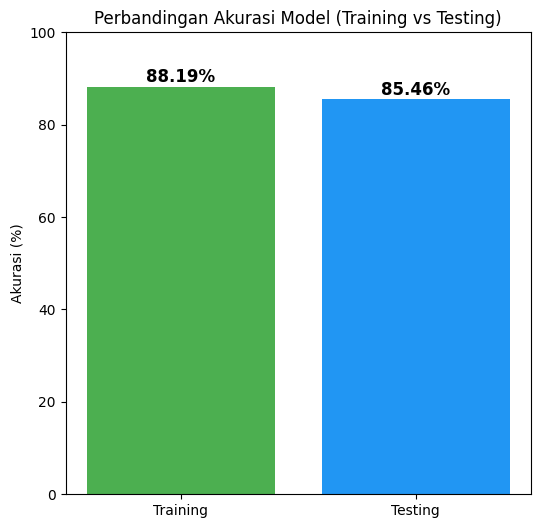

In [6]:
# Visualisasi Akurasi Training vs Testing
plt.figure(figsize=(6, 6))
bar_labels = ['Training', 'Testing']
bar_values = [r2_train * 100, r2_test * 100]
colors = ['#4caf50', '#2196f3']

plt.bar(bar_labels, bar_values, color=colors)
plt.ylim(0, 100)
plt.ylabel('Akurasi (%)')
plt.title('Perbandingan Akurasi Model (Training vs Testing)')

for i, v in enumerate(bar_values):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontsize=12, fontweight='bold')

plt.show()



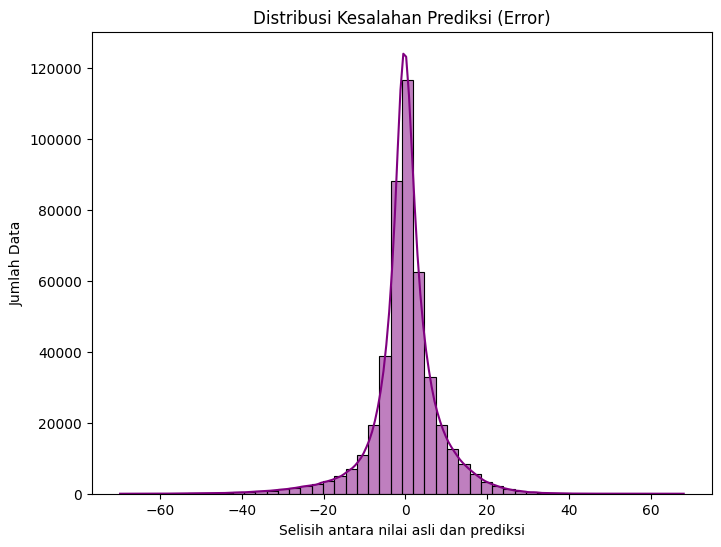

In [7]:
# Visualisasi Distribusi Error
error = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(error, bins=50, kde=True, color='purple')
plt.title('Distribusi Kesalahan Prediksi (Error)')
plt.xlabel('Selisih antara nilai asli dan prediksi')
plt.ylabel('Jumlah Data')
plt.show()



C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


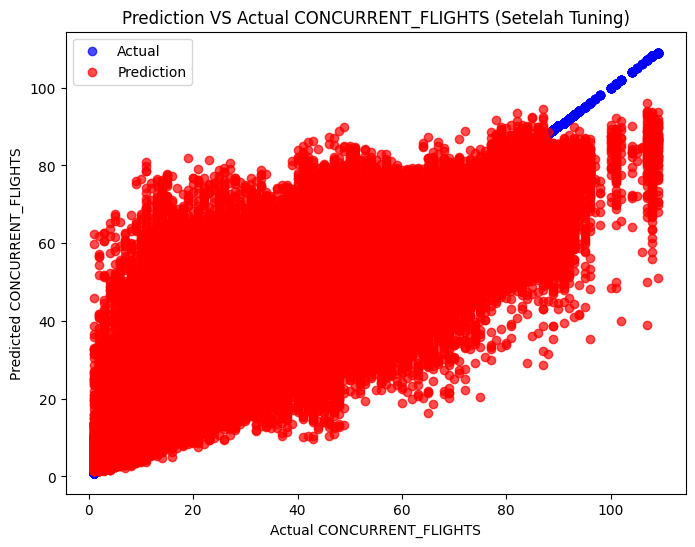

In [8]:
# Visualisasi - Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(y_test, y_pred, color='red', label='Prediction', alpha=0.7)
plt.xlabel('Actual CONCURRENT_FLIGHTS')
plt.ylabel('Predicted CONCURRENT_FLIGHTS')
plt.title('Prediction VS Actual CONCURRENT_FLIGHTS (Setelah Tuning)')
plt.legend()
plt.show()



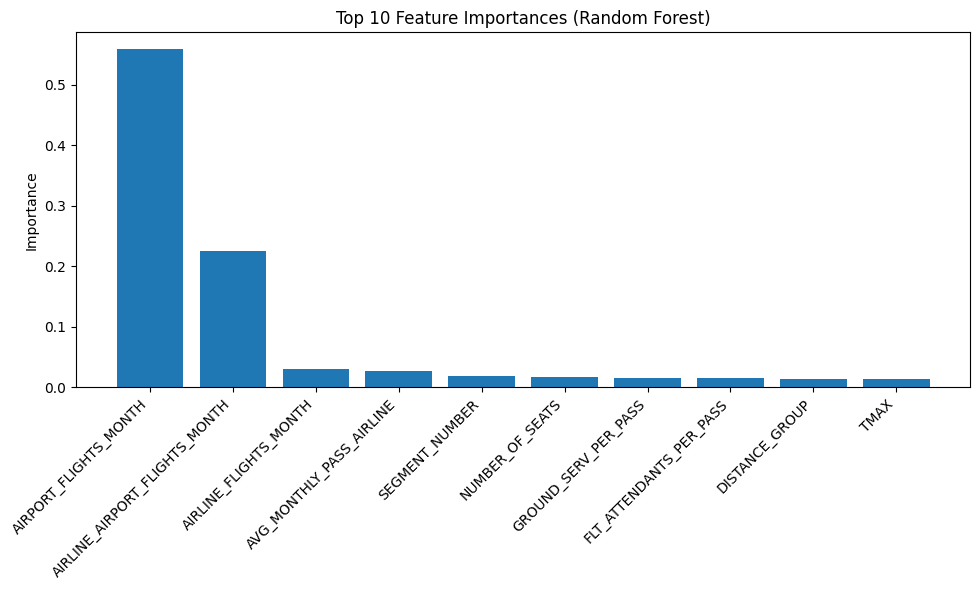

In [9]:
# 🔹 Ambil feature importance dari model
importances = best_model.feature_importances_
feature_names = X_train.columns

# 🔹 Buat dataframe untuk sorting
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

# 🔹 Plot top 10 feature importances
plt.figure(figsize=(10, 6))
plt.bar(feat_importance_df['Feature'], feat_importance_df['Importance'])
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


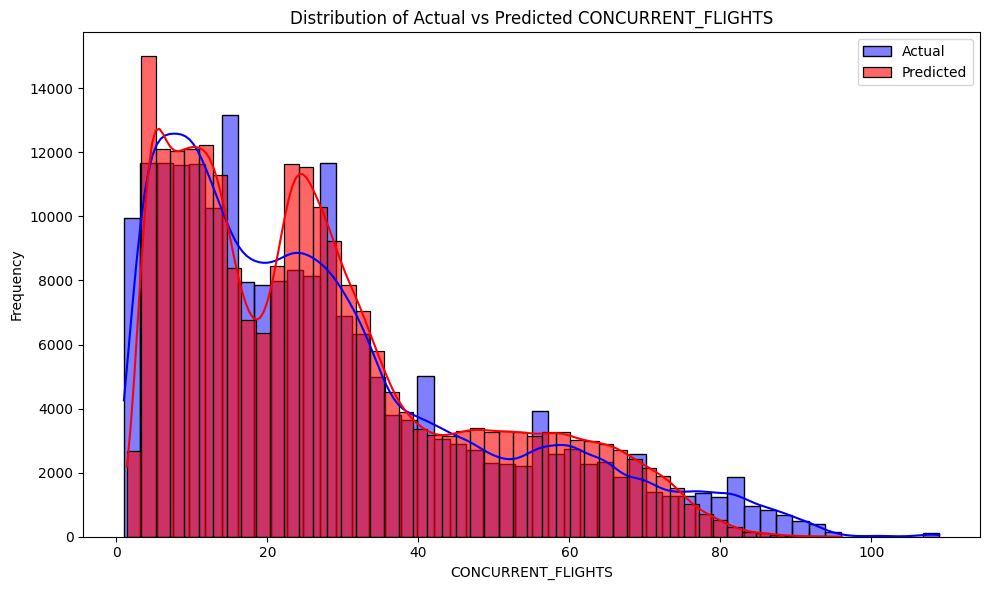

In [10]:
# 🔹 Visualisasi distribusi nilai aktual vs prediksi
plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=50, kde=True, color='blue', label='Actual', stat="frequency")
sns.histplot(y_pred, bins=50, kde=True, color='red', label='Predicted', stat="frequency", alpha=0.6)
plt.title('Distribution of Actual vs Predicted CONCURRENT_FLIGHTS')
plt.xlabel('CONCURRENT_FLIGHTS')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
import joblib

joblib.dump(best_model, 'random_forest_best_model.pkl')


['random_forest_best_model.pkl']